In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess your data
def load_data(file_path):
    # Load your tabular dataset
    data = pd.read_csv(file_path)
    # Perform any necessary preprocessing
    # For simplicity, we will just use numerical columns
    data = data.select_dtypes(include=[np.number])
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data, scaler

# Define the generator model
def build_generator(latent_dim, data_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=latent_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(data_dim, activation='sigmoid')  # Output layer for tabular data
    ])
    return model

# Define the discriminator (critic) model
def build_critic(data_dim):
    model = tf.keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=data_dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)  # Output a single value (Wasserstein loss)
    ])
    return model

# Define the WGAN
class WGAN(tf.keras.Model):
    def __init__(self, generator, critic, latent_dim):
        super(WGAN, self).__init__()
        self.generator = generator
        self.critic = critic
        self.latent_dim = latent_dim
        self.gp_weight = 10.0  # Gradient penalty weight

    def compile(self, g_optimizer, c_optimizer, g_loss_fn, c_loss_fn):
        super(WGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
        self.g_loss_fn = g_loss_fn
        self.c_loss_fn = c_loss_fn

    def gradient_penalty(self, batch_size, real_data, fake_data):
        alpha = tf.random.normal([batch_size, 1])
        interpolated = alpha * real_data + (1 - alpha) * fake_data

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]

        # Train critic
        for _ in range(5):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_data = self.generator(random_latent_vectors, training=True)
                real_logits = self.critic(real_data, training=True)
                fake_logits = self.critic(fake_data, training=True)
                c_loss = self.c_loss_fn(real_logits, fake_logits)
                gp = self.gradient_penalty(batch_size, real_data, fake_data)
                c_loss += gp * self.gp_weight
            grads = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_data = self.generator(random_latent_vectors, training=True)
            fake_logits = self.critic(fake_data, training=True)
            g_loss = self.g_loss_fn(fake_logits)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"g_loss": g_loss, "c_loss": c_loss}

# Define the loss functions
def generator_loss(fake_logits):
    return -tf.reduce_mean(fake_logits)

def critic_loss(real_logits, fake_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

# Prepare data
file_path = 'crop_recommendation.csv'
data, scaler = load_data(file_path)
data_dim = data.shape[1]
latent_dim = 32

# Build and compile the WGAN model
generator = build_generator(latent_dim, data_dim)
critic = build_critic(data_dim)
wgan = WGAN(generator, critic, latent_dim)

g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
c_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004)
wgan.compile(g_optimizer, c_optimizer, generator_loss, critic_loss)

# Train the WGAN model
wgan.fit(data, batch_size=32, epochs=1000)

# Generate synthetic data
random_latent_vectors = tf.random.normal(shape=(1000, latent_dim))
synthetic_data = generator(random_latent_vectors)
synthetic_data = scaler.inverse_transform(synthetic_data)

# Convert to DataFrame
synthetic_data_df = pd.DataFrame(synthetic_data, columns=[f"Feature_{i}" for i in range(data_dim)])
print(synthetic_data_df.head())


Epoch 1/1000
69/69 [==============================] - 6s 10ms/step - g_loss: 0.6562 - c_loss: -0.1241
Epoch 2/1000
69/69 [==============================] - 1s 10ms/step - g_loss: 0.3065 - c_loss: -0.3109
Epoch 3/1000
69/69 [==============================] - 1s 11ms/step - g_loss: 0.2524 - c_loss: -0.2707
Epoch 4/1000
69/69 [==============================] - 1s 10ms/step - g_loss: 0.1141 - c_loss: -0.1865
Epoch 5/1000
69/69 [==============================] - 1s 10ms/step - g_loss: -0.0417 - c_loss: -0.1099
Epoch 6/1000
69/69 [==============================] - 1s 10ms/step - g_loss: -0.2700 - c_loss: -0.1156
Epoch 7/1000
69/69 [==============================] - 1s 10ms/step - g_loss: -0.3024 - c_loss: -0.1314
Epoch 8/1000
69/69 [==============================] - 1s 10ms/step - g_loss: -0.6421 - c_loss: -0.1578
Epoch 9/1000
69/69 [==============================] - 1s 15ms/step - g_loss: -0.5371 - c_loss: -0.1596
Epoch 10/1000
69/69 [==============================] - 1s 16ms/step - g_loss:

In [13]:
real_data = pd.read_csv('/content/sample_data/cc23.csv')

synthetic_data = pd.read_csv('synth1.csv')

from table_evaluator import TableEvaluator

# Assuming real_data and synthetic_data are pandas DataFrames containing your real and synthetic datasets
table_evaluator = TableEvaluator(real_data, synthetic_data)

# Evaluate the synthetic data
table_evaluator.evaluate()

# Generate visualizations and report
table_evaluator.visual_evaluation()

TypeError: TableEvaluator.evaluate() missing 1 required positional argument: 'target_col'

        Column  Real Mean  Synthetic Mean  Real Std  Synthetic Std  \
0            N    50.5518         56.1752   36.9173        37.4008   
1            P    53.3627         53.7127   32.9859        32.3134   
2            K    48.1491         50.3103   50.6479        48.9521   
3  temperature    25.6162         26.5789    5.0637         2.9978   
4     humidity    71.4818         71.1644   22.2638        20.7880   
5           ph     6.4695          6.3295    0.7739         0.4165   

   Real Median  Synthetic Median  Real Skew  Synthetic Skew  Real Kurtosis  \
0      37.0000           43.0728     0.5097          0.4432        -1.0582   
1      51.0000           51.6635     1.0108          1.1815         0.8603   
2      32.0000           35.6469     2.3752          2.4431         4.4494   
3      25.5987           26.3217     0.1849          0.4154         1.2326   
4      80.4731           77.3587    -1.0917         -1.1346         0.3021   
5       6.4250            6.3519     0.28

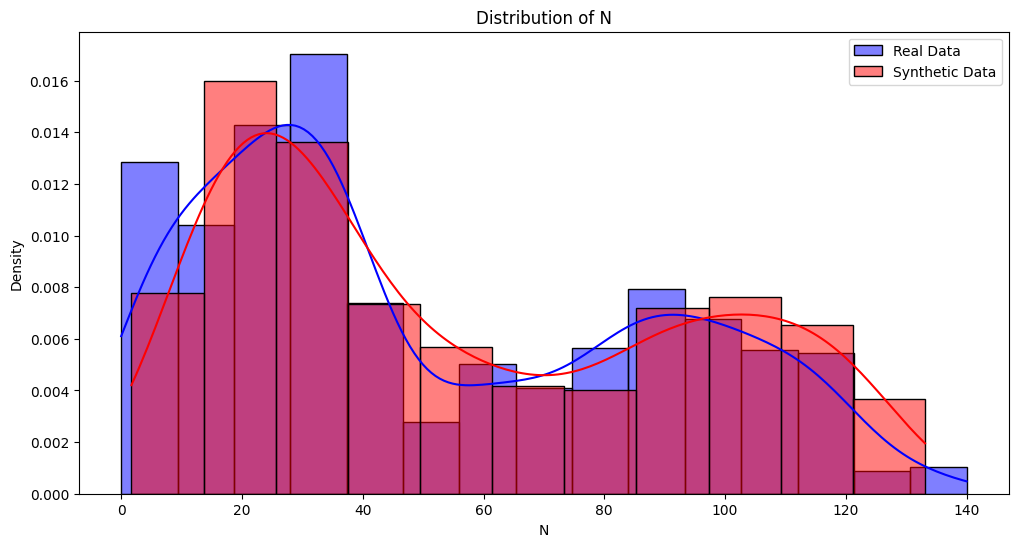

<ipython-input-17-716edfe3c1ad>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


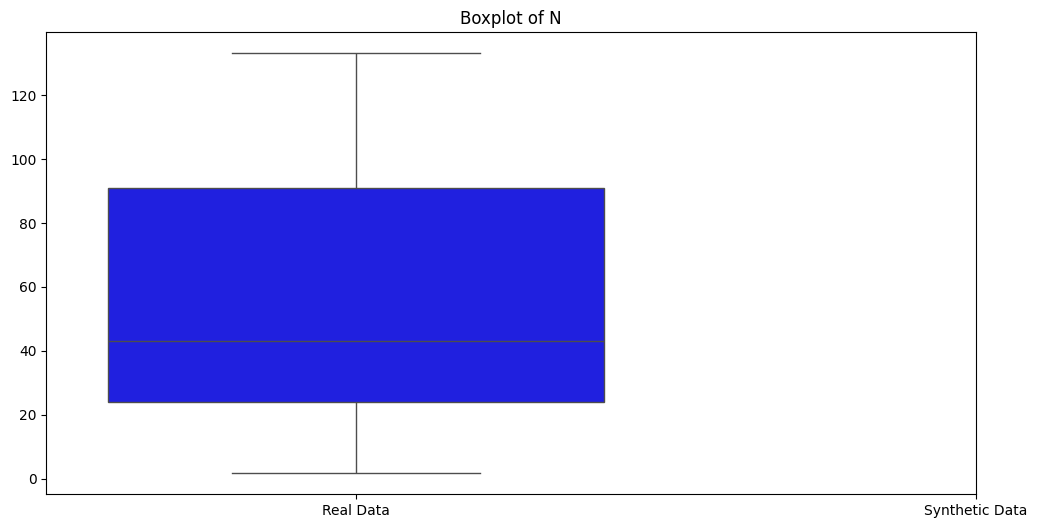

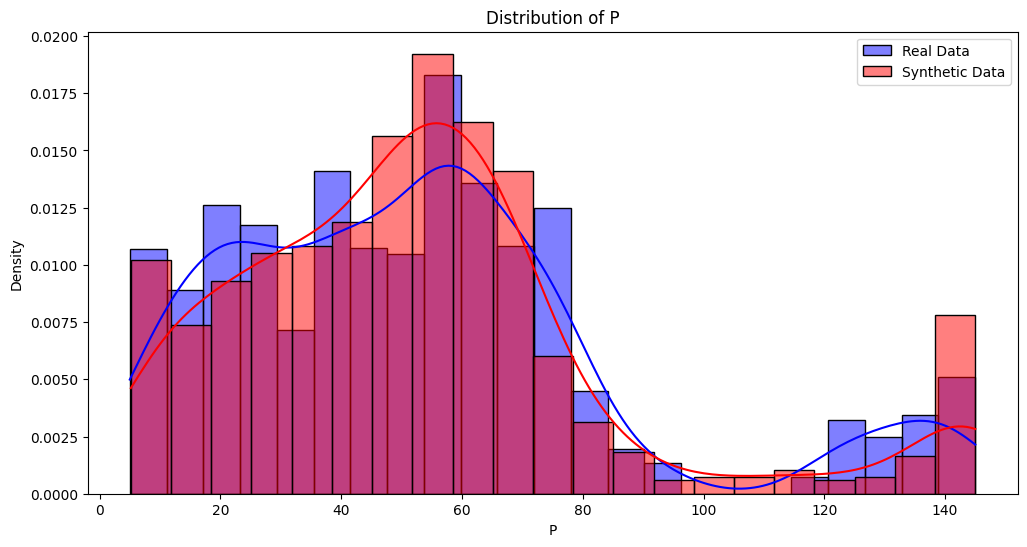

<ipython-input-17-716edfe3c1ad>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


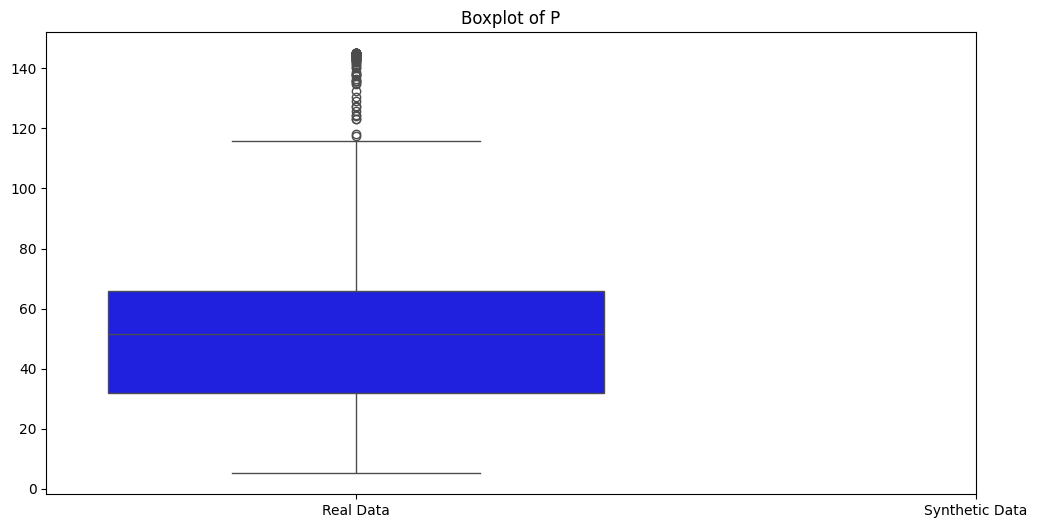

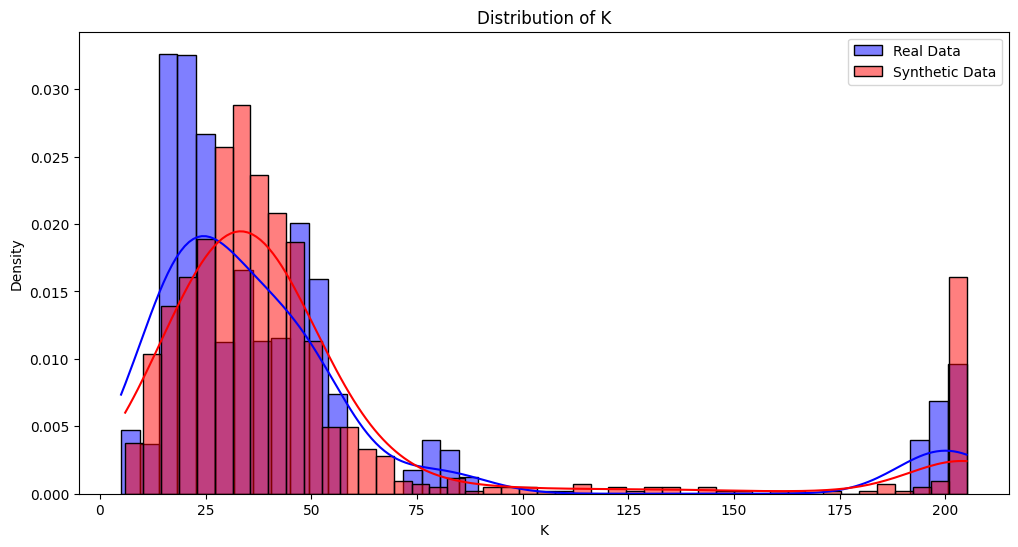

<ipython-input-17-716edfe3c1ad>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


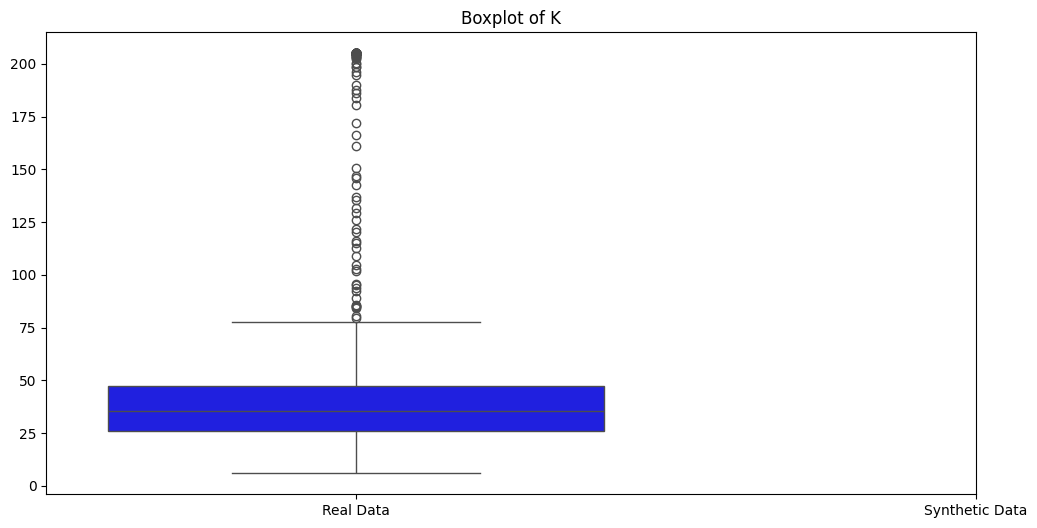

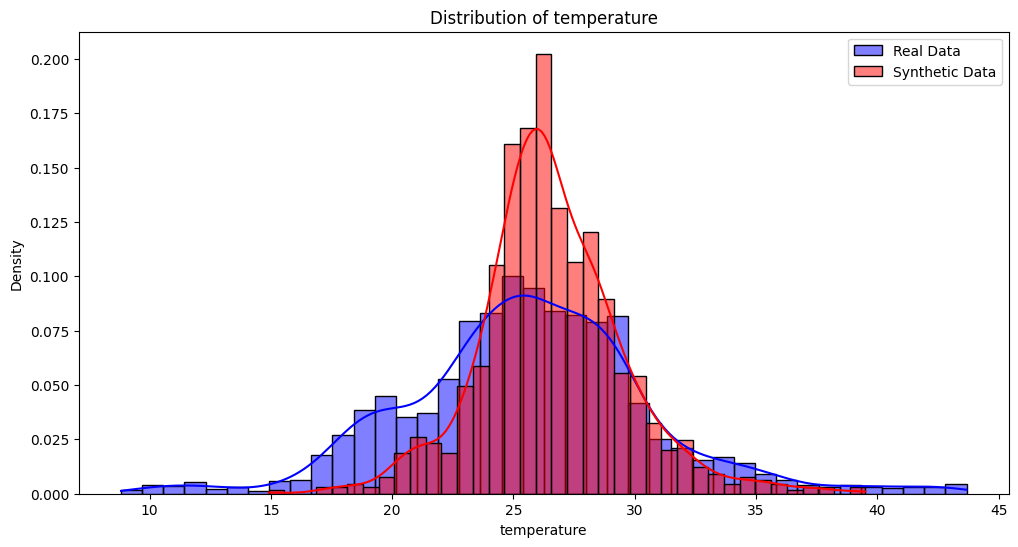

<ipython-input-17-716edfe3c1ad>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


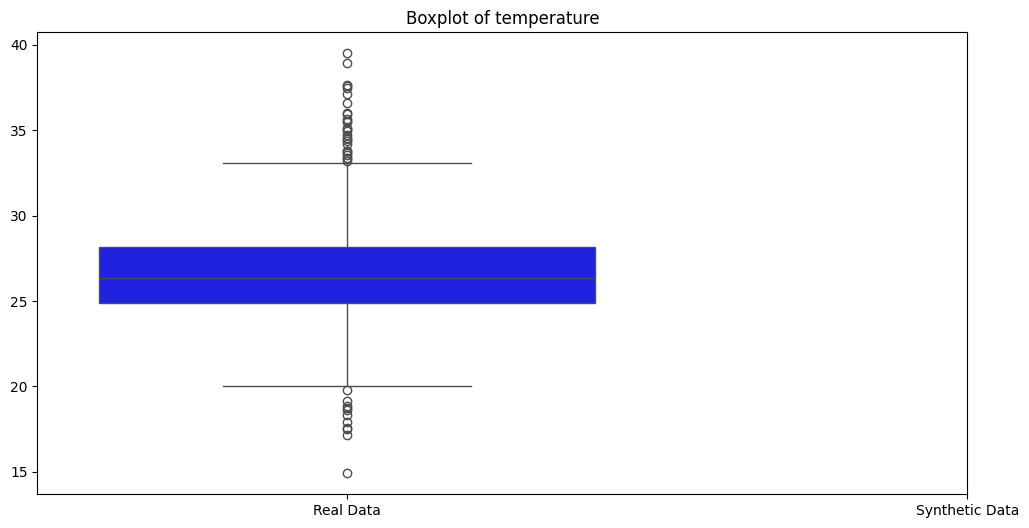

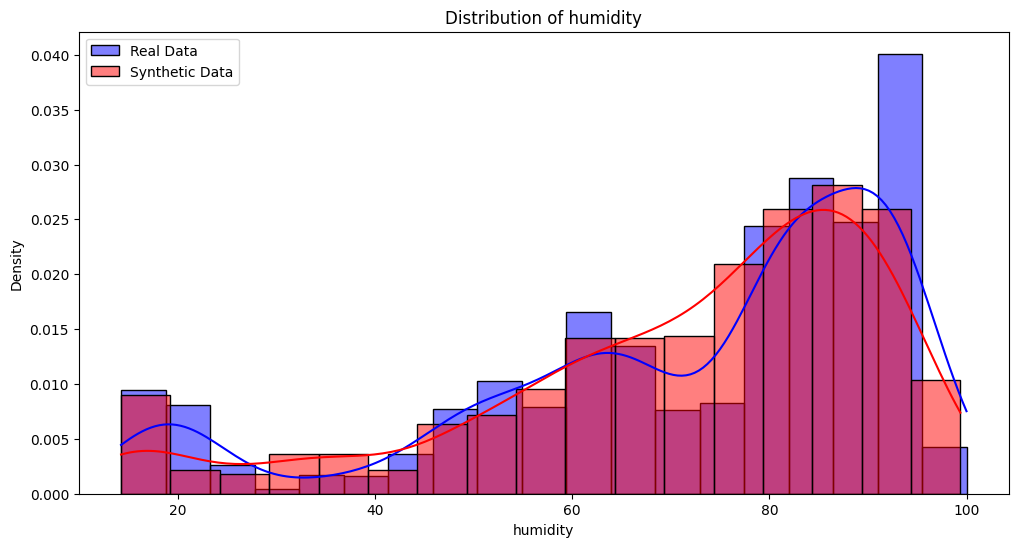

<ipython-input-17-716edfe3c1ad>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


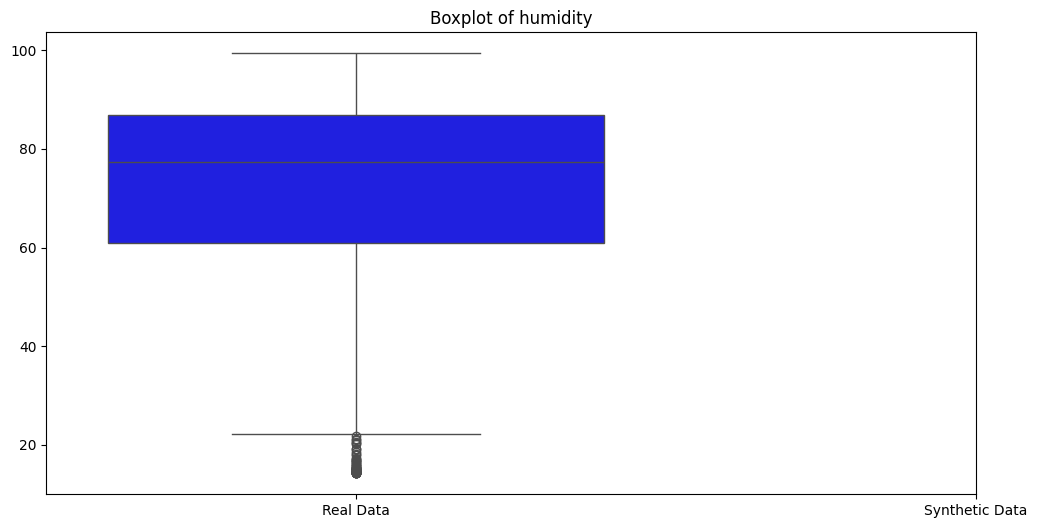

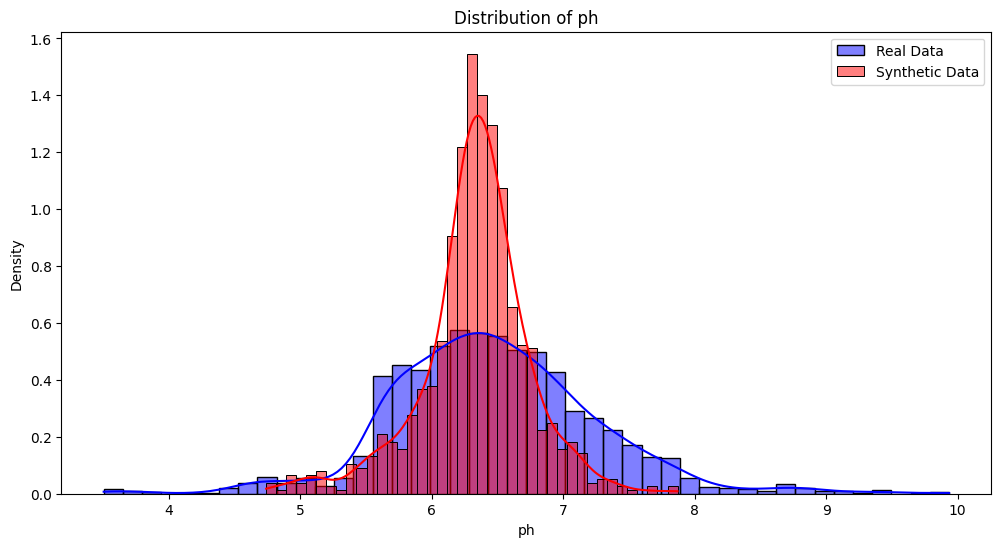

<ipython-input-17-716edfe3c1ad>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


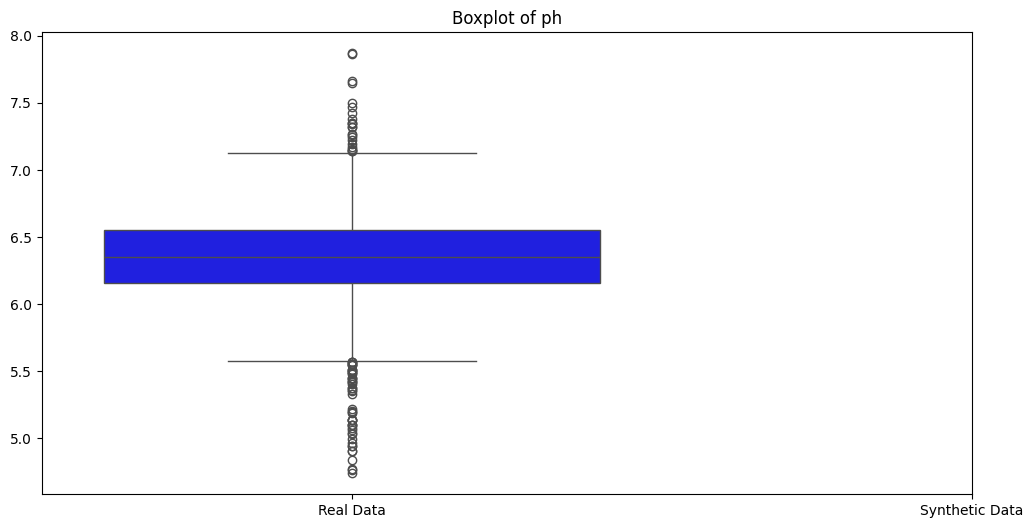

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (137,) and arg 1 with shape (1000,).

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp, entropy

# Load real and synthetic data from CSV files
real_data = pd.read_csv('/content/sample_data/cc23.csv')
synthetic_data = pd.read_csv('synth1.csv')

# Ensure column compatibility
common_columns = real_data.columns.intersection(synthetic_data.columns)

# Function to compare statistical properties
def compare_statistics(real, synthetic, columns):
    stats = []
    for col in columns:
        real_mean = real[col].mean()
        synth_mean = synthetic[col].mean()
        real_std = real[col].std()
        synth_std = synthetic[col].std()
        real_median = real[col].median()
        synth_median = synthetic[col].median()
        real_skew = real[col].skew()
        synth_skew = synthetic[col].skew()
        real_kurt = real[col].kurt()
        synth_kurt = synthetic[col].kurt()

        ks_stat, ks_p = ks_2samp(real[col], synthetic[col])

        stats.append({
            'Column': col,
            'Real Mean': real_mean,
            'Synthetic Mean': synth_mean,
            'Real Std': real_std,
            'Synthetic Std': synth_std,
            'Real Median': real_median,
            'Synthetic Median': synth_median,
            'Real Skew': real_skew,
            'Synthetic Skew': synth_skew,
            'Real Kurtosis': real_kurt,
            'Synthetic Kurtosis': synth_kurt,
            'KS Statistic': ks_stat,
            'KS p-value': ks_p
        })
    return pd.DataFrame(stats)

# Function to visualize distributions
def visualize_distributions(real, synthetic, columns):
    for col in columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(real[col], color='blue', kde=True, stat='density', label='Real Data')
        sns.histplot(synthetic[col], color='red', kde=True, stat='density', label='Synthetic Data')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])
        plt.xticks([0, 1], ['Real Data', 'Synthetic Data'])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Function to calculate distance metrics
def calculate_distances(real, synthetic, columns):
    distances = []
    for col in columns:
        wd = wasserstein_distance(real[col], synthetic[col])
        kl_div = entropy(real[col].value_counts(normalize=True), synthetic[col].value_counts(normalize=True))
        distances.append({
            'Column': col,
            'Wasserstein Distance': wd,
            'KL Divergence': kl_div
        })
    return pd.DataFrame(distances)

# Comparing statistics
statistics_comparison = compare_statistics(real_data, synthetic_data, common_columns)
print(statistics_comparison)

# Visualizing distributions
visualize_distributions(real_data, synthetic_data, common_columns)

# Calculating distance metrics
distance_metrics = calculate_distances(real_data, synthetic_data, common_columns)
print(distance_metrics)


        Column  Real Mean  Synthetic Mean  Real Std  Synthetic Std  \
0            N    50.5518         56.1752   36.9173        37.4008   
1            P    53.3627         53.7127   32.9859        32.3134   
2            K    48.1491         50.3103   50.6479        48.9521   
3  temperature    25.6162         26.5789    5.0637         2.9978   
4     humidity    71.4818         71.1644   22.2638        20.7880   
5           ph     6.4695          6.3295    0.7739         0.4165   

   Real Median  Synthetic Median  Real Skew  Synthetic Skew  Real Kurtosis  \
0      37.0000           43.0728     0.5097          0.4432        -1.0582   
1      51.0000           51.6635     1.0108          1.1815         0.8603   
2      32.0000           35.6469     2.3752          2.4431         4.4494   
3      25.5987           26.3217     0.1849          0.4154         1.2326   
4      80.4731           77.3587    -1.0917         -1.1346         0.3021   
5       6.4250            6.3519     0.28

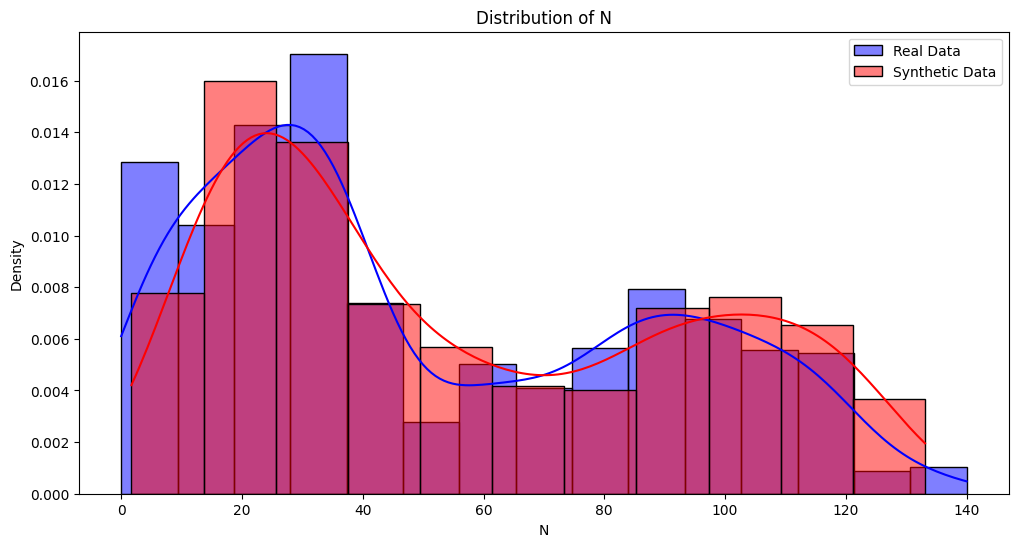

<ipython-input-18-425d35244f3f>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


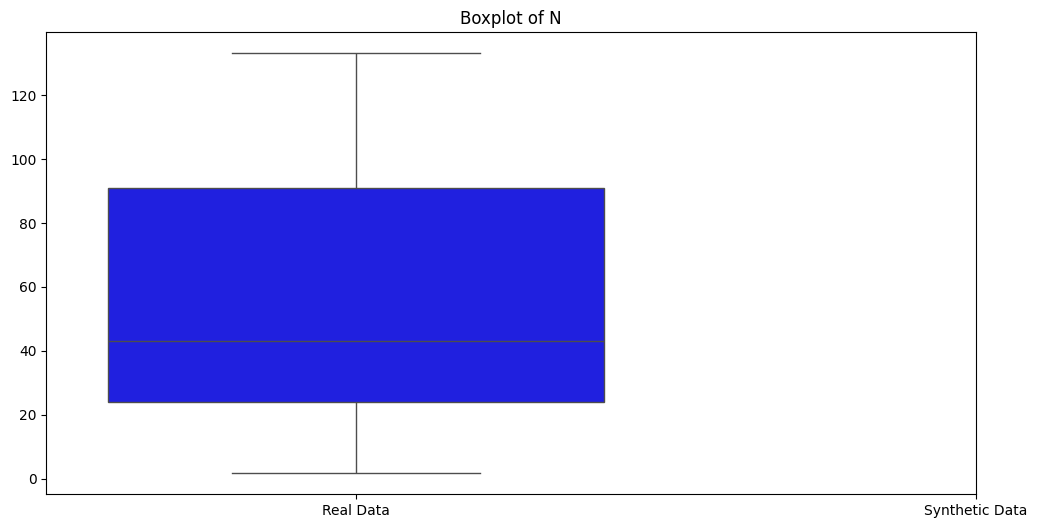

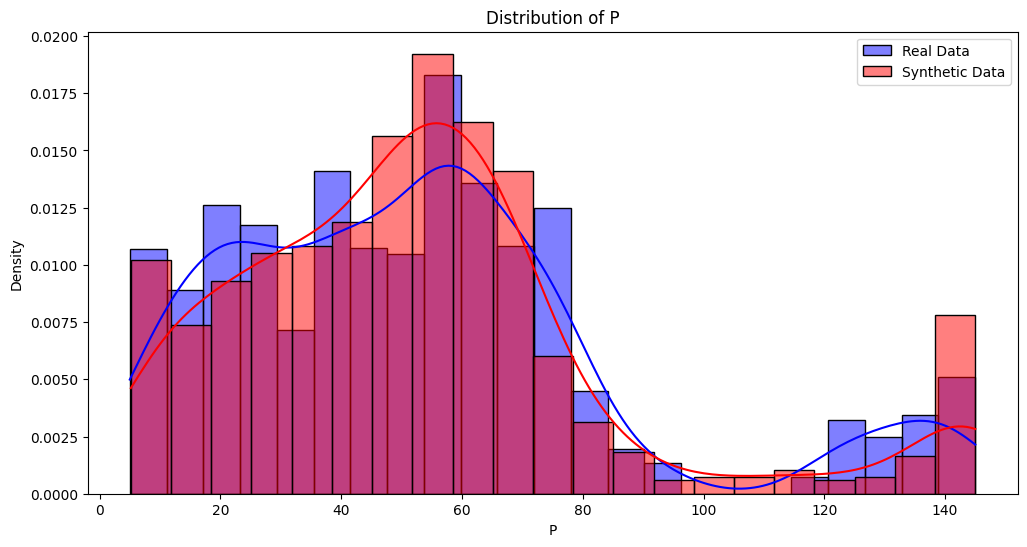

<ipython-input-18-425d35244f3f>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


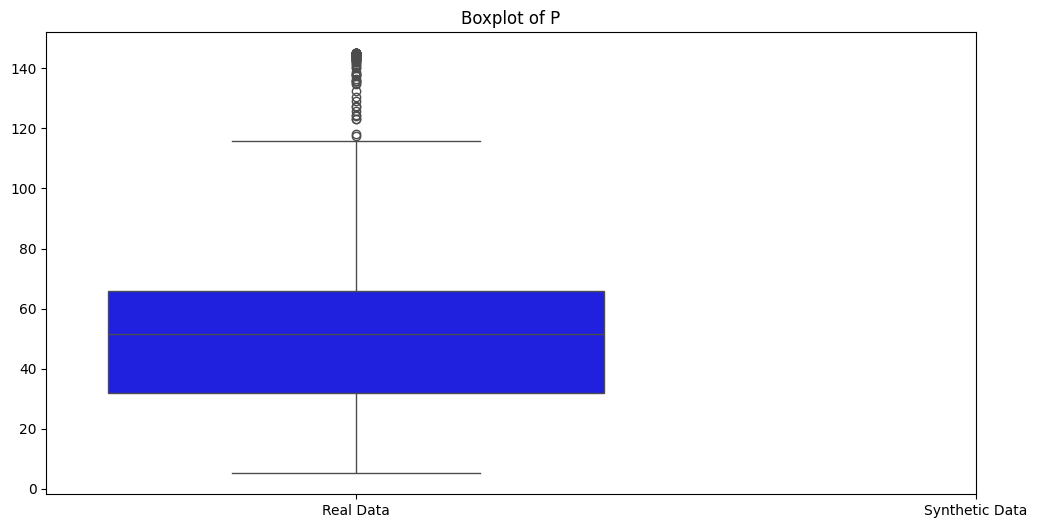

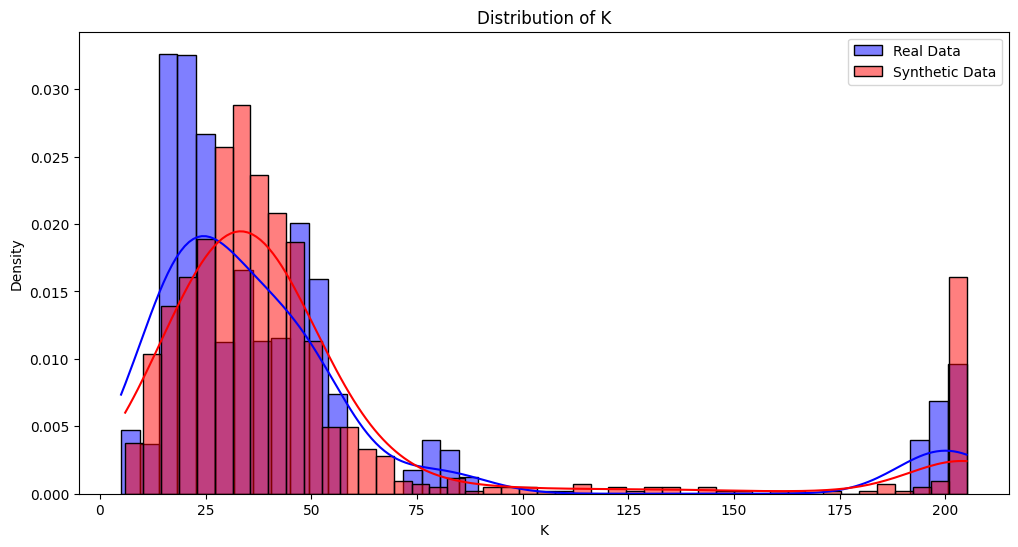

<ipython-input-18-425d35244f3f>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


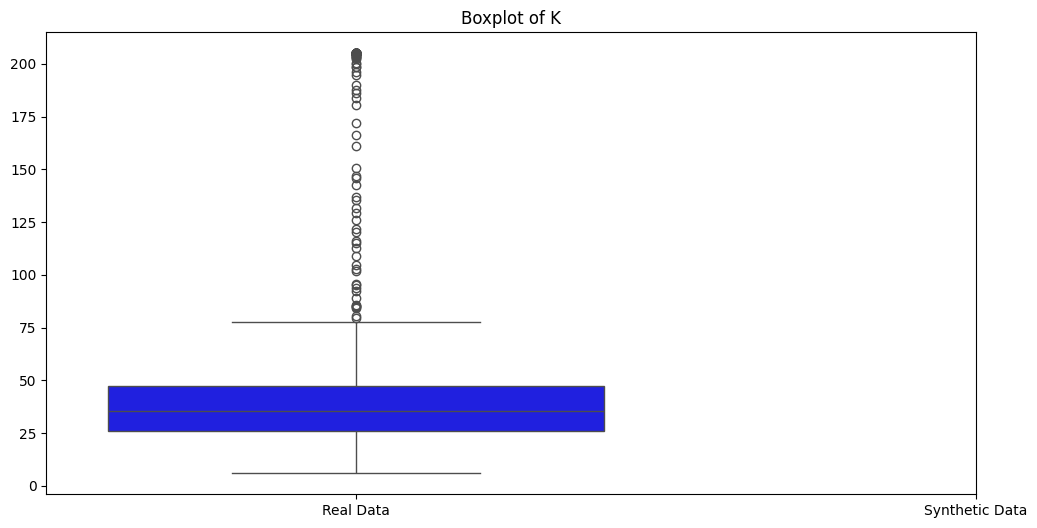

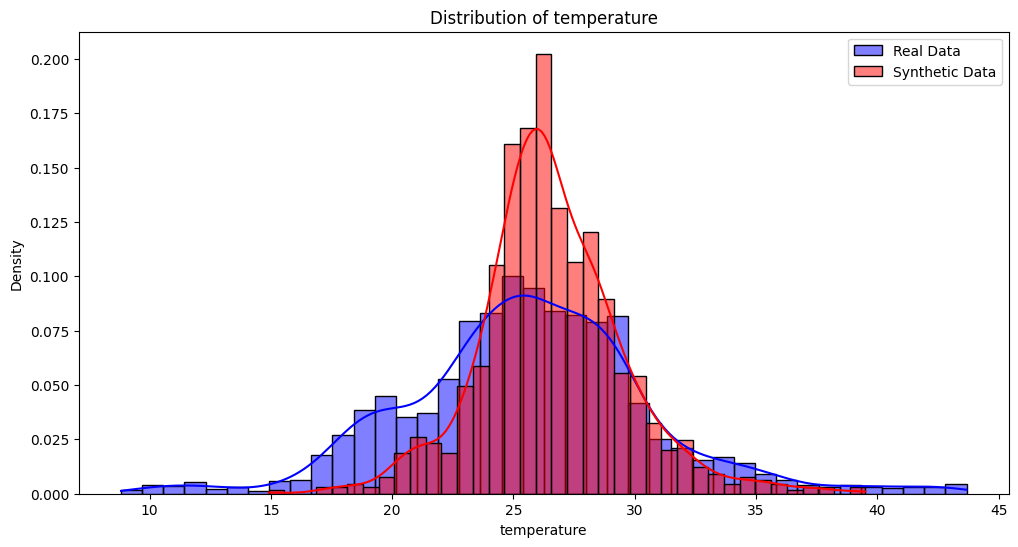

<ipython-input-18-425d35244f3f>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


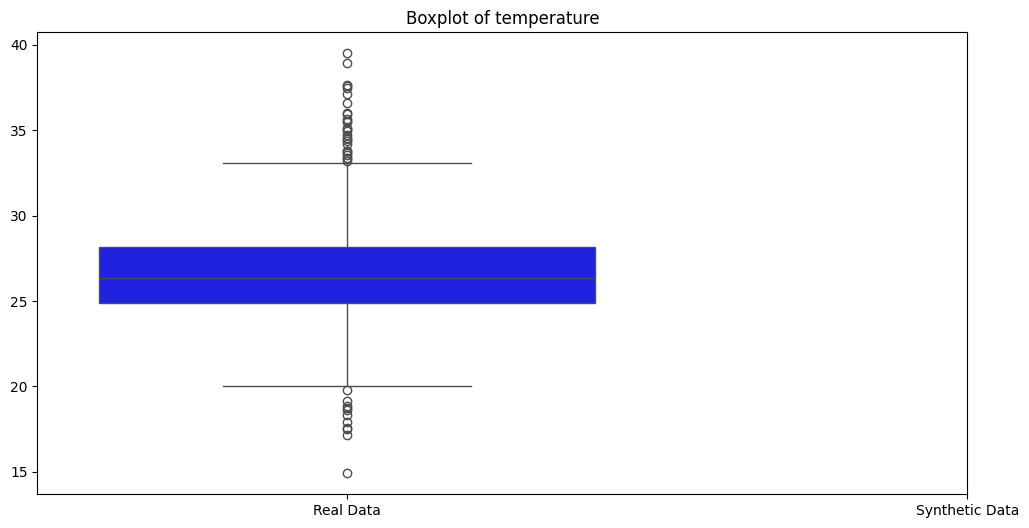

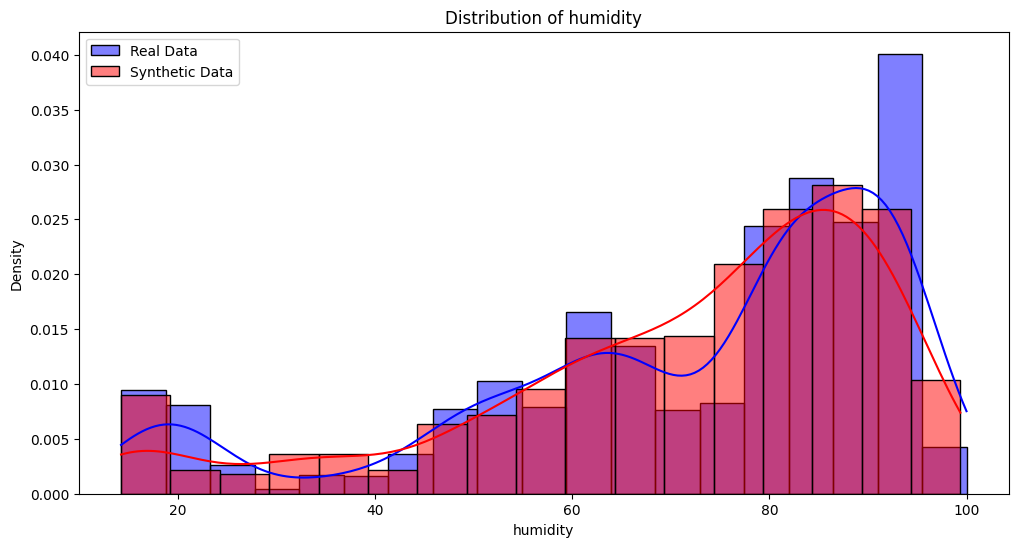

<ipython-input-18-425d35244f3f>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


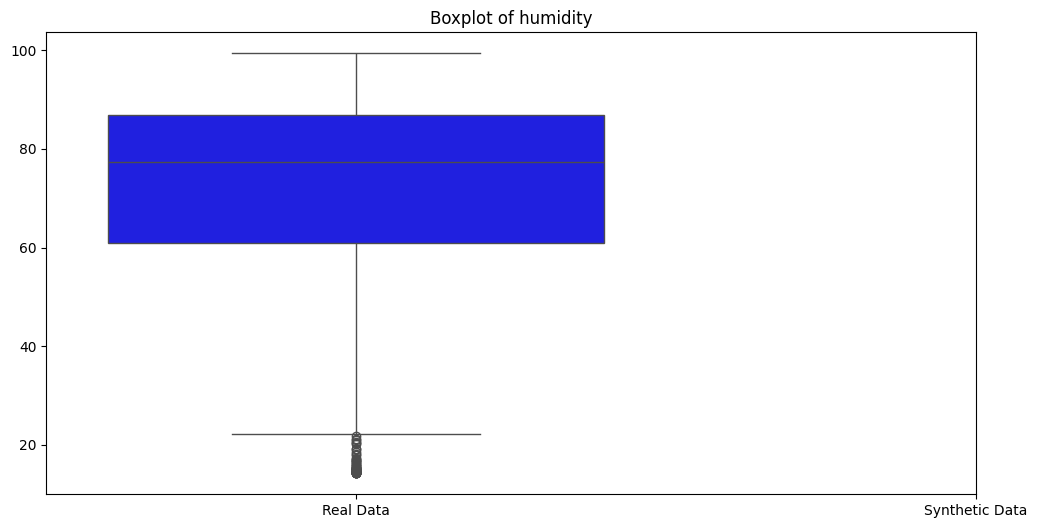

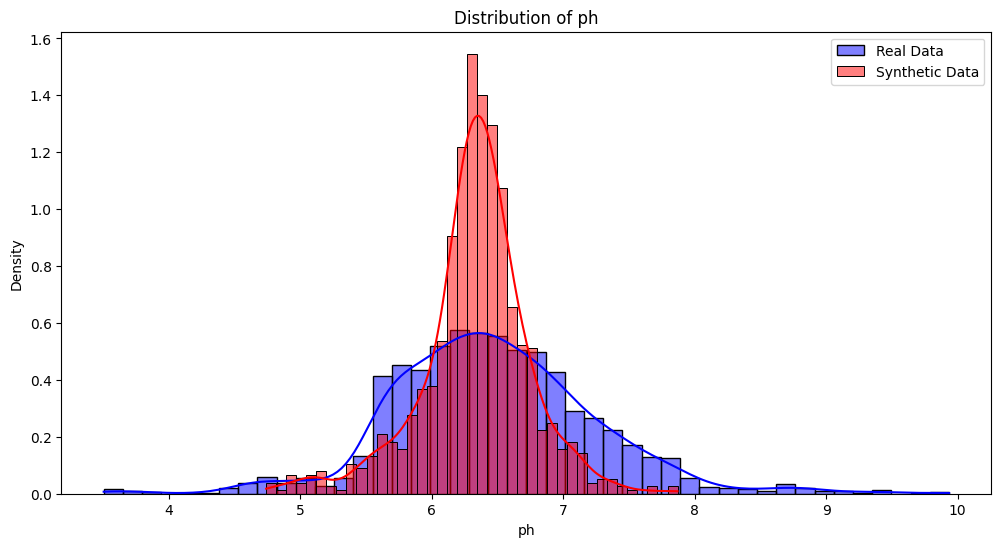

<ipython-input-18-425d35244f3f>:59: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])


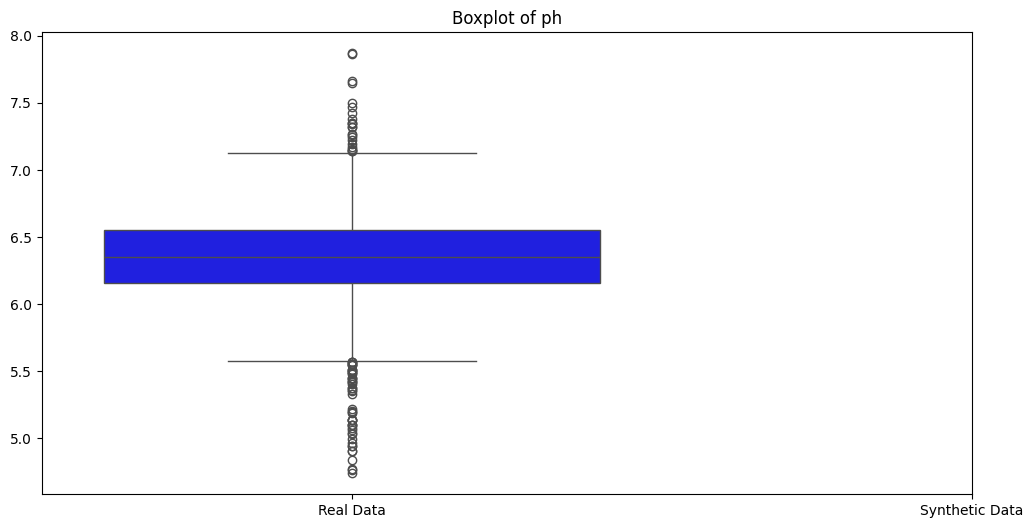

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (129,) and arg 1 with shape (1000,).

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp, entropy

# Load real and synthetic data from CSV files
real_data = pd.read_csv('/content/sample_data/cc23.csv')
synthetic_data = pd.read_csv('synth1.csv')

# Ensure column compatibility
common_columns = real_data.columns.intersection(synthetic_data.columns)

# Function to compare statistical properties
def compare_statistics(real, synthetic, columns):
    stats = []
    for col in columns:
        real_mean = real[col].mean()
        synth_mean = synthetic[col].mean()
        real_std = real[col].std()
        synth_std = synthetic[col].std()
        real_median = real[col].median()
        synth_median = synthetic[col].median()
        real_skew = real[col].skew()
        synth_skew = synthetic[col].skew()
        real_kurt = real[col].kurt()
        synth_kurt = synthetic[col].kurt()

        ks_stat, ks_p = ks_2samp(real[col], synthetic[col])

        stats.append({
            'Column': col,
            'Real Mean': real_mean,
            'Synthetic Mean': synth_mean,
            'Real Std': real_std,
            'Synthetic Std': synth_std,
            'Real Median': real_median,
            'Synthetic Median': synth_median,
            'Real Skew': real_skew,
            'Synthetic Skew': synth_skew,
            'Real Kurtosis': real_kurt,
            'Synthetic Kurtosis': synth_kurt,
            'KS Statistic': ks_stat,
            'KS p-value': ks_p
        })
    return pd.DataFrame(stats)

# Function to visualize distributions
def visualize_distributions(real, synthetic, columns):
    for col in columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(real[col], color='blue', kde=True, stat='density', label='Real Data')
        sns.histplot(synthetic[col], color='red', kde=True, stat='density', label='Synthetic Data')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.boxplot(data=[real[col], synthetic[col]], palette=["blue", "red"])
        plt.xticks([0, 1], ['Real Data', 'Synthetic Data'])
        plt.title(f'Boxplot of {col}')
        plt.show()

# Function to calculate distance metrics
def calculate_distances(real, synthetic, columns):
    distances = []
    min_len = min(len(real), len(synthetic))

    for col in columns:
        real_sample = real[col].sample(n=min_len, random_state=1)
        synthetic_sample = synthetic[col].sample(n=min_len, random_state=1)

        wd = wasserstein_distance(real_sample, synthetic_sample)
        kl_div = entropy(real_sample.value_counts(normalize=True), synthetic_sample.value_counts(normalize=True))
        distances.append({
            'Column': col,
            'Wasserstein Distance': wd,
            'KL Divergence': kl_div
        })
    return pd.DataFrame(distances)

# Comparing statistics
statistics_comparison = compare_statistics(real_data, synthetic_data, common_columns)
print(statistics_comparison)

# Visualizing distributions
visualize_distributions(real_data, synthetic_data, common_columns)

# Calculating distance metrics
distance_metrics = calculate_distances(real_data, synthetic_data, common_columns)
print(distance_metrics)


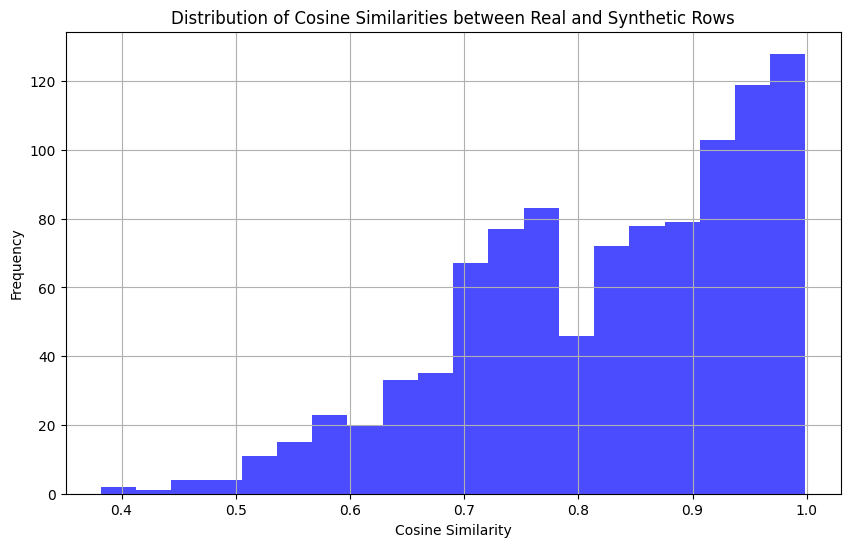

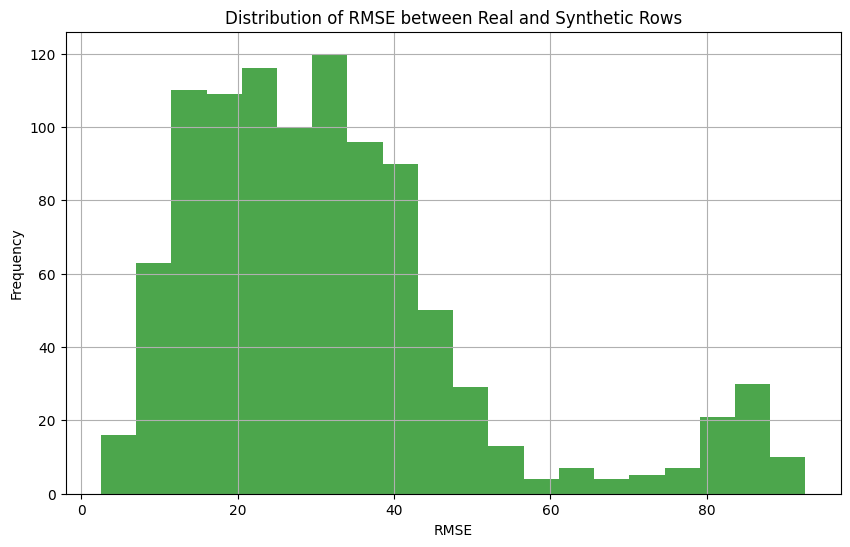

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error

# Load real and synthetic data from CSV files
real_data = pd.read_csv('/content/sample_data/cc23.csv')
synthetic_data = pd.read_csv('synth1.csv')

# Ensure column compatibility
common_columns = real_data.columns.intersection(synthetic_data.columns)

# Function to calculate row-wise cosine similarity
def calculate_cosine_similarity(real, synthetic, columns):
    cos_similarities = []
    for index, (real_row, synth_row) in enumerate(zip(real[columns].values, synthetic[columns].values)):
        cos_sim = 1 - cosine(real_row, synth_row)
        cos_similarities.append(cos_sim)
    return cos_similarities

# Function to calculate row-wise RMSE (Root Mean Squared Error)
def calculate_rmse(real, synthetic, columns):
    rmses = []
    for index, (real_row, synth_row) in enumerate(zip(real[columns].values, synthetic[columns].values)):
        rmse = np.sqrt(mean_squared_error(real_row, synth_row))
        rmses.append(rmse)
    return rmses

# Calculate cosine similarities and RMSE for each row
cosine_similarities = calculate_cosine_similarity(real_data, synthetic_data, common_columns)
rmse_values = calculate_rmse(real_data, synthetic_data, common_columns)

# Visualize trends: Cosine Similarity
plt.figure(figsize=(10, 6))
plt.hist(cosine_similarities, bins=20, color='blue', alpha=0.7)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities between Real and Synthetic Rows')
plt.grid(True)
plt.show()

# Visualize trends: RMSE
plt.figure(figsize=(10, 6))
plt.hist(rmse_values, bins=20, color='green', alpha=0.7)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE between Real and Synthetic Rows')
plt.grid(True)
plt.show()


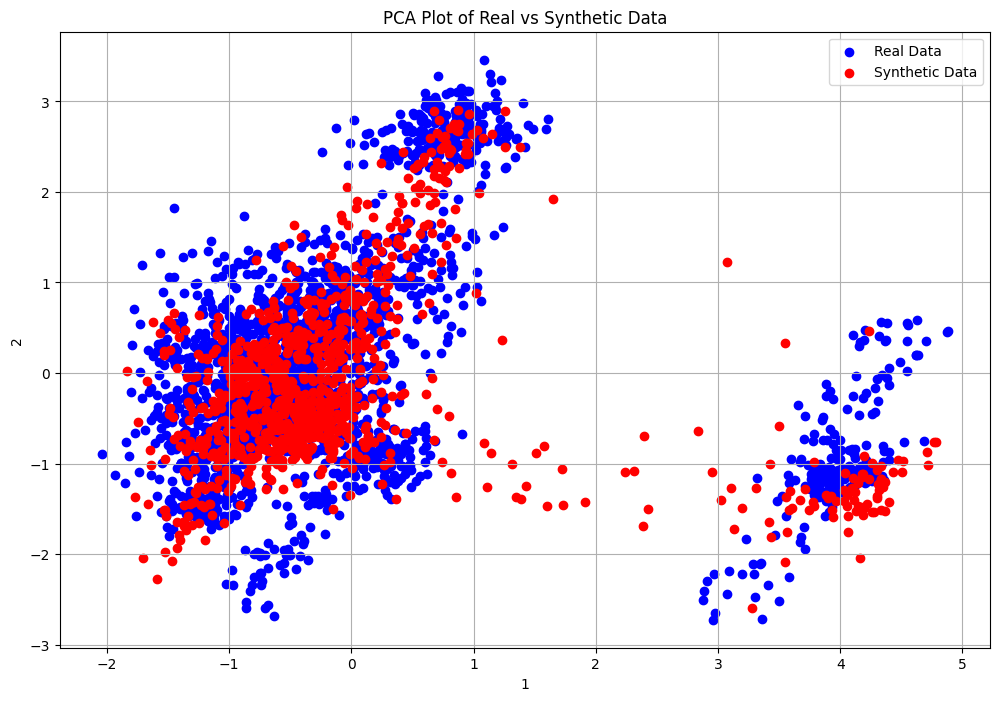

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load real and synthetic data from CSV files
real_data = pd.read_csv('/content/sample_data/cc23.csv')
synthetic_data = pd.read_csv('synth1.csv')

# Ensure column compatibility
common_columns = real_data.columns.intersection(synthetic_data.columns)

# Combine datasets for scaling
combined_data = pd.concat([real_data[common_columns], synthetic_data[common_columns]], axis=0, ignore_index=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Separate into real and synthetic components
real_pca = pca_result[:len(real_data)]
synthetic_pca = pca_result[len(real_data):]

# Plot PCA results
plt.figure(figsize=(12, 8))
plt.scatter(real_pca[:, 0], real_pca[:, 1], color='blue', label='Real Data')
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1], color='red', label='Synthetic Data')
plt.title('PCA Plot of Real vs Synthetic Data')
plt.xlabel('1')
plt.ylabel('2')
plt.legend()
plt.grid(True)
plt.show()
